<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>


# IMDB - Machine Learning

In this notebook we continue with the IMDB dataset and start building machine learning models to predict the review score.

## Content:
 1. **Feature Engineering**. In this section we will engineer the input features of our models. We start with the Bag-of-Words features. These features can be obtained using [scikit-learn's bag of words tool](https://scikit-learn.org/stable/modules/feature_extraction.html?highlight=bag%20words). Whereafter we will try to visualize these features. 
 2. **Model Building**. We import, train and compare a logistic regression classifier, a random forest classifier and a IF-IDF classifier. 


In [1]:
# load some common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
def download_file(url, path):
    """
    Download file and save it to the defined location
    
    https://stackoverflow.com/questions/37573483/progress-bar-while-download-file-over-http-with-requests/37573701
    """
    import requests
    from tqdm.notebook import tqdm
    import os
    
    
    if os.path.exists(path):
        print('File "{}" already exists. Skipping download.'.format(path))
        return
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

In [ ]:
# read pickle files
import pickle

download_file('https://github.com/illyakaynov/masterclass-nlp/blob/master/Case-IMBD_reviews/train_data.pickle?raw=true',
             path='train_data.pickle')

download_file('https://github.com/illyakaynov/masterclass-nlp/blob/master/Case-IMBD_reviews/test_data.pickle?raw=true',
             path='test_data.pickle')


filename = './train_data.pickle'
with open(filename, 'rb') as file_object:
    train_data = pickle.load(file_object)
    
filename = './test_data.pickle'
with open(filename, 'rb') as file_object:
    test_data = pickle.load(file_object)    

# Feature engineering
We will use the `CountVectorizer` module from the `sklearn` package to convert the data to a bag-of-words.

We will convert each review to a vector of 5000 elements, for which the n'th item corresponds to the amount of occurences of the n'th word in the review. 

Example, n'th word = "horrible", n'th element = 3 means that the word "horrible" occured 3 times.


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer object
vectorizer = CountVectorizer(analyzer     = "word",   \
                             tokenizer    = None,    \
                             preprocessor = None, \
                             stop_words   = None,   \
                             max_features = 5_000) 

# Use the training dataset to fit the vectorizer. Next, transform the data.
# Both steps can be done in the 'fit_transform' method.
train_data_features = vectorizer.fit_transform(train_data[0])

# Convert to numpy array for convience
train_data_features = train_data_features.toarray()

In [4]:
# print size of train data
train_data_features.shape

(25000, 5000)

In [5]:
# print names of features
vocab = vectorizer.get_feature_names()
vocab[:10]   # print first 10 names

['abandoned',
 'abc',
 'abilities',
 'ability',
 'able',
 'aboard',
 'absence',
 'absent',
 'absolute',
 'absolutely']

In [6]:
# plot histogram of features showing how often specific words occur
features = []

# Sum up the counts of each vocabulary word
counts = np.sum(train_data_features, axis=0)

for feature_name, count in zip(vocab, counts):
    features.append((count, feature_name))
    
features.sort(key=lambda x:x[0], reverse=True)
features[:10]   # plot first 10 items

[(44196, 'movie'),
 (39974, 'film'),
 (26731, 'one'),
 (20220, 'like'),
 (14975, 'good'),
 (12576, 'time'),
 (12456, 'would'),
 (12440, 'even'),
 (11557, 'story'),
 (11477, 'see')]

# Feature engineering, visualzing the data.
To inspect the data further, we make a histogram of the first and last 100 words.

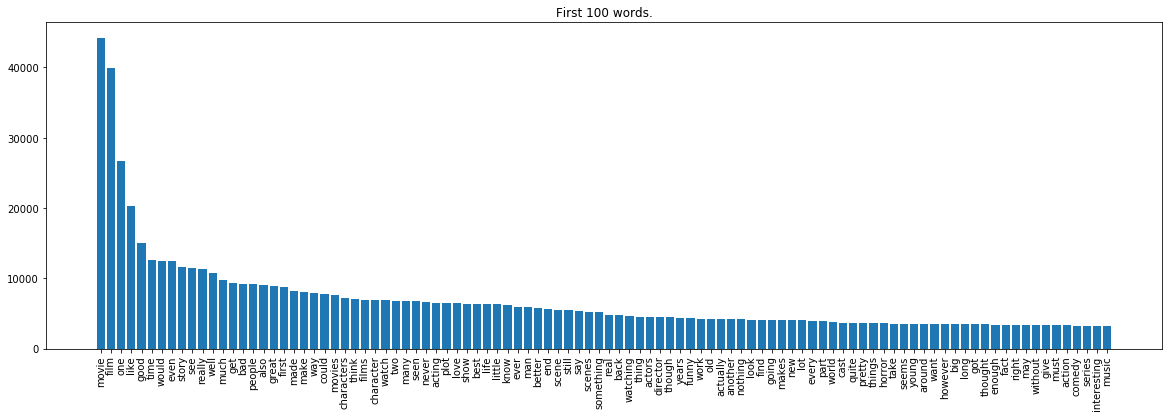

In [7]:
n = 100 # number of words to plot

# transform data structure for plotting
labels = [features[i][1] for i in range(n)]
counts = [features[i][0] for i in range(n)]

plt.figure(figsize=(20,6))
plt.bar(labels, counts)
plt.xticks(range(n), labels, rotation='vertical')
plt.title(f'First {n} words.');

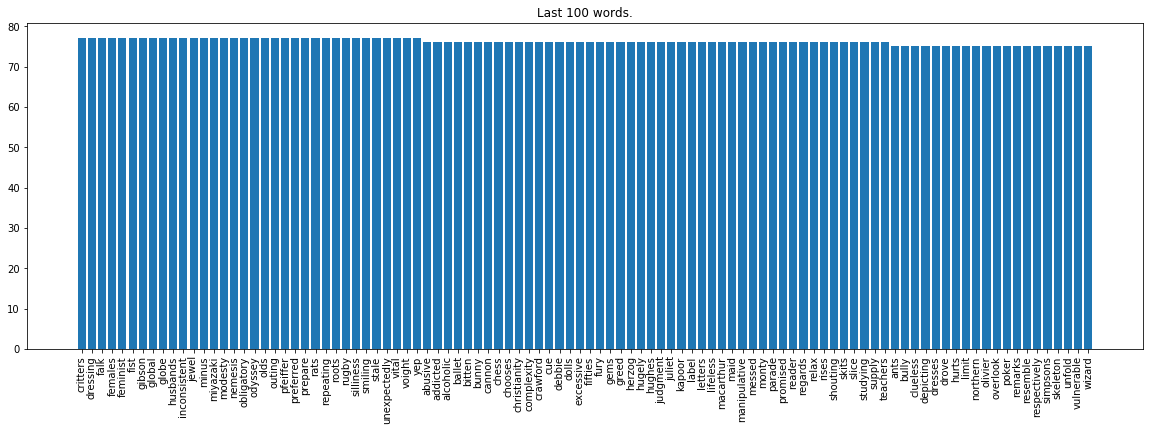

In [8]:
n = 100 # number of words to plot

# transform data structure for plotting
labels = [features[-i][1] for i in range(n,0,-1)]
counts = [features[-i][0] for i in range(n,0,-1)]

plt.figure(figsize=(20,6))
plt.bar(labels, counts)
plt.xticks(range(n), labels, rotation='vertical');
plt.title(f'Last {n} words.');

# Feature engineering, preparing train and test datasets.

In [9]:
test_data_features = vectorizer.transform(test_data[0])
test_data_features = test_data_features.toarray()

In [10]:
# create datasets (numpy arrays) for machine learning
X_train, y_train = train_data_features, np.array(train_data[1])
X_test, y_test = test_data_features, np.array(test_data[1])

In [11]:
X_train.shape

(25000, 5000)

In [12]:
word_counts = X_train.sum(axis=0)
word_counts.shape

(5000,)

## Visualzing the word frequencies:
Some words are more used in reviews than other words. To get some insight in the distribution of word frequency in document, we calculate per word how often they are used in all reviews, and in negative and positive reviews. Next, we plot the distributions.

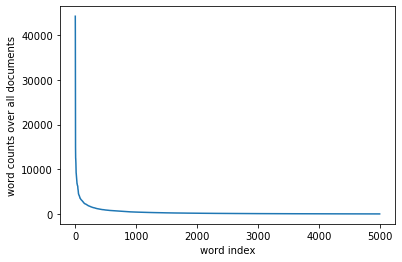

In [13]:
plt.plot(np.sort(word_counts)[::-1])
plt.xlabel('word index')
plt.ylabel('word counts over all documents');

As often occurs in NLP the distribution of word frequency is a heavy long tail. A few words are used on almost all documents (reviews) and many words are only used in some documents (reviews).

To get more insight, we plot the most top-N words per class.

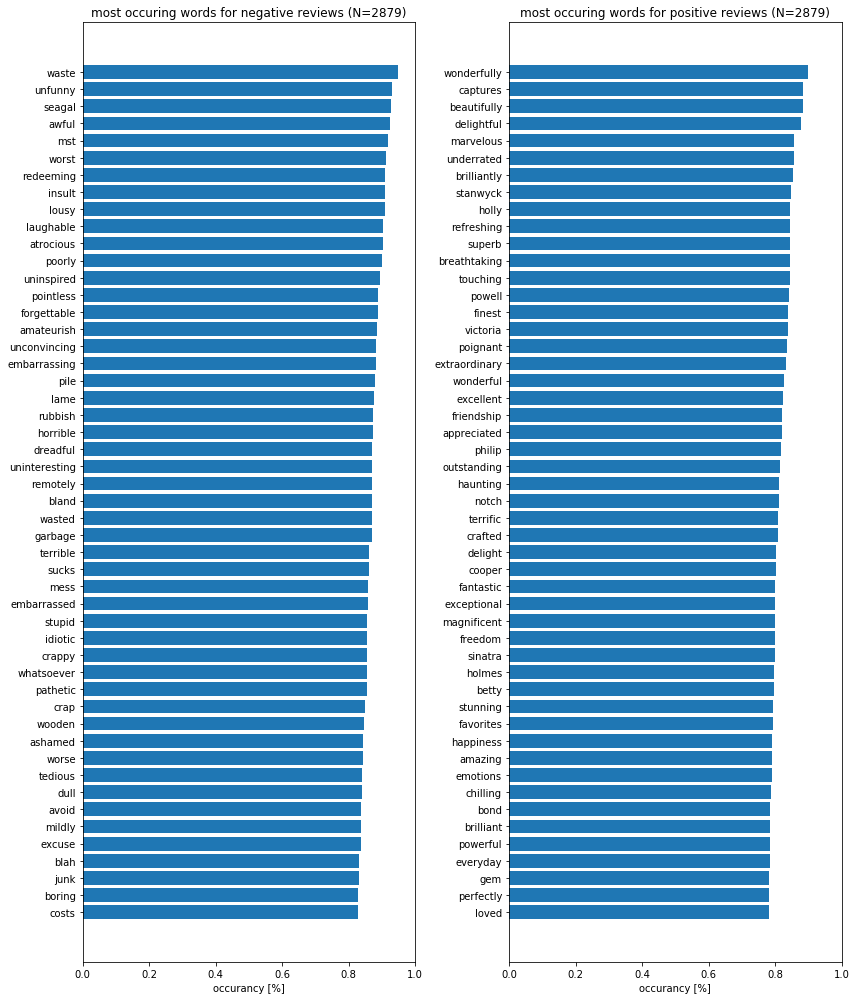

In [14]:
n_labels = 2
N = X_train.shape[1]

# count words per class
word_counts = np.zeros((N, n_labels))
word_counts[:,0] = X_train[y_train==0].sum(axis=0)
word_counts[:,1] = X_train[y_train==1].sum(axis=0)

# remove end of the heavy tail
word_count_threshold = 150
idx_most_occuring_words = (word_counts.sum(axis=1)>=word_count_threshold)
word_counts = word_counts[idx_most_occuring_words]
vocab_most_occuring = np.array(vocab)[idx_most_occuring_words]

# normalize word counts so that for a specific words the counts of negative
# and positive reviews add up to 1
normalized_word_counts = word_counts / word_counts.sum(axis=1)[:,np.newaxis]

# sort the word counts
idx = np.argsort(normalized_word_counts[:,0])[::-1]

# plot results
fig, axs = plt.subplots(1, 2, figsize=(12,14))

n_plot = 50 # number of words to plot
axs[0].barh(vocab_most_occuring[idx[:n_plot]][::-1], normalized_word_counts[idx[:n_plot][::-1],0])
axs[0].set_title(f'most occuring words for negative reviews (N={word_counts.shape[0]})')
axs[0].set_xlim([0,1])
axs[0].set_xlabel('occurancy [%]')

axs[1].barh(vocab_most_occuring[idx[::-1][:n_plot]][::-1], normalized_word_counts[idx[::-1][:n_plot],1][::-1])
axs[1].set_title(f'most occuring words for positive reviews (N={word_counts.shape[0]})')
axs[1].set_xlim([0,1])
axs[1].set_xlabel('occurancy [%]')

plt.tight_layout();

# Model building
This section contains utility functions for visualizing the accuracy whereafter we train and validate the following different models:
1. Logistic Regression for classification.
2. Random Forest classifier.
3. IF-IDF.

For more information:
see http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


In [15]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          ax=None,
                          figsize=(8,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax==None:
        _, ax = plt.subplot(1, 1, figsize=figsize)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, pad=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.tick_params(axis='x', rotation=90)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')    
    ax.set_ylim((len(classes) - 0.5, -0.5))

    
def accuracy(y, y_pred):
    return np.sum(y==y_pred)/len(y)


def plot_model_performance(model, X_train, y_train, X_test, y_test, label_names, figsize=(8,6)):
    """Support function for quickly plotting model performance."""
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs.ravel()

    y_train_pred = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    plot_confusion_matrix(cm_train, 
                          list(label_names), 
                          title='Training - accuracy: {:.2f}'.format(accuracy(y_train, y_train_pred)),
                          ax=axs[0])

    y_test_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm_test, 
                          list(label_names), 
                          title='Test - accuracy: {:.2f}'.format(accuracy(y_test, y_test_pred)),
                          ax=axs[1])

    plt.tight_layout()    

## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

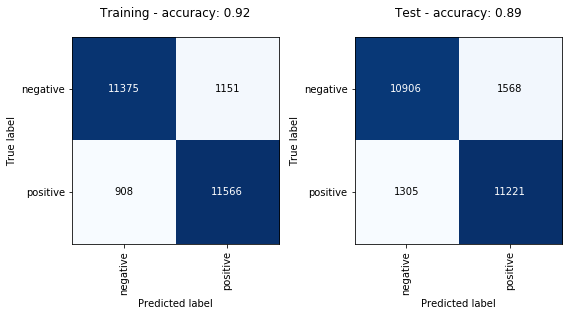

In [31]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

In [32]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup         

# Function from 01_imdb_preprocessing.ipynb
def clean_text(s):
    # 2. Remove html markup
    html_free_text = BeautifulSoup(s).get_text()
    
    # 5. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                          " ",                   # The pattern to replace it with
                          html_free_text )       # The text to search

    # 4. Split into lower-case words
    lower_case = letters_only.lower()
    words = lower_case.split()
    
    # 3. Remove stop words
    # 5. Remove all words with 2 or 1 letters
    words = [w for w in words if (not w in stopwords.words("english")) and (len(w)>2)]
    
    # 6. Return words as a single string again
    return " ".join(words)

We can test our model by writing our own reviews and let the model predict the sentiment.

In [15]:
import nltk
nltk.download('stopwords')

review = clean_text("i liked this movie")
model.predict(vectorizer.transform([review]).toarray())[0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ikayn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'clean_text' is not defined

In [34]:
review = clean_text("don't waste your time on this movie")
model.predict(vectorizer.transform([review]).toarray())[0]

0

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
model = RandomForestClassifier(n_estimators = 100, max_depth=6) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
model = model.fit( X_train, y_train )

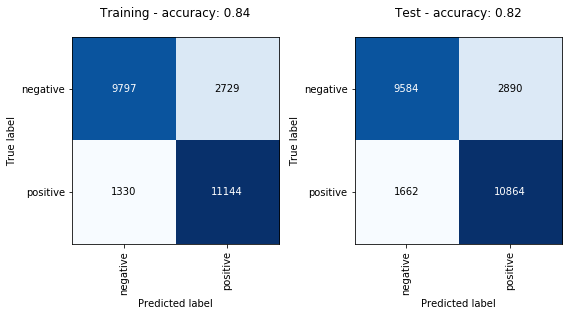

In [36]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

# IF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer object
vectorizer = TfidfVectorizer(max_features = 5_000) 

# Use the training dataset to fit the vectorizer. Next, transform the data.
# Both steps can be done in the 'fit_transform' method.
train_data_features = vectorizer.fit_transform(train_data[0])

# Convert to numpy array for convience
train_data_features = train_data_features.toarray()

In [28]:
test_data_features = vectorizer.transform(test_data[0])
test_data_features = test_data_features.toarray()

In [29]:
# create datasets (numpy arrays) for machine learning
X_train, y_train = train_data_features, np.array(train_data[1])
X_test, y_test = test_data_features, np.array(test_data[1])

Now, rerun the model building part from above.